In [1]:
import json
import os

from datetime import datetime, timezone
from dateutil import tz

import branca.colormap as cm
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns

TZ = pytz.timezone('America/Los_Angeles')
sns.set_style('whitegrid')

In [14]:
corridor_segments = {
    0: {
        2749,
        2751,
        2752,
        2753,
        2754,
        2755,
        2756,
        2757
    },
    1: {
        12200,
        12201,
        12202,
        12203,
        12204
    },
    2: {
        13532,
        13533,
        13534,
        13535,
        13536
    },
    3: {
        14585,
        14586,
        14587,
        14589,
        14590,
        14591,
        14243
    },
    4: {
        8510,
        8511,
        8512,
        8513,
        8514
    },
    5: {
        13221,
        13220,
        13219,
        13218,
        13217
    },
    6: {
        18045,
        18046,
        18047,
        18048,
        18049
    },
    7: {
        19235,
        19234,
        11333,
        11331,
        11330,
        11329,
        19212
    },
    8: {
        12369,
        12366,
        12365,
        12364,
        12363
    }
}
corridor_names = ['2nd Ave; Pike to James',
                 'Pike; 3rd to 9th',
                 'Westlake; Denny to Mercer',
                 'E Olive/E John; Denny to 10th',
                 '9th Ave; Alder to Columbia',
                 'University Way; Campus Pkwy to 45th',
                  'Pacific; 15th to Montlake',
                  'NW Market/Leary; 24th to 15th',
                  'Rainier; S Bayview to MLK',
                  '108th Ave; 4th to 12th']

In [2]:
# Location for the local data
path = './transit_vis/data/to_upload'
files = os.listdir(path)

# Join all the data which is saved in different csv for each day
# frames = [pd.read_csv(f"{path}/{filename}", dtype={'trip_short_name': str, 'route_short_name': str}) for filename in files]
# all_data = pd.concat(frames)
# all_data.to_csv(f"{path}/../all_data.csv")
# all_data.head()

# If already processed, load the data here and comment out above
all_data = pd.read_csv(f"{path}/../all_data.csv", dtype={'trip_short_name': str, 'route_short_name': str})

# Rename and style
# all_data['speed_m_s'] = all_data['avg_speed_m_s']
#all_data = all_data[all_data['at_stop'] == True]
sns.set_style('whitegrid')

In [49]:
# Calculate Pace
all_data['speed_mph'] = all_data['speed_m_s']*2.237
all_data['pace_s_mi'] = 1 / (all_data['speed_m_s']*.0006214)

# Add date to the data
all_data['day'] = pd.to_datetime(all_data['locationtime'], unit='s')
all_data['day'] = all_data['day'].dt.strftime('%Y-%m-%d')

# Add corridor id to the data
def get_dict_key(value, corridor_dict):
    for corridor in corridor_dict:
        if value in corridor_dict[corridor]:
            return corridor
    return -1
all_data['corridor_id'] = all_data['seg_compkey'].apply(get_dict_key, args=(corridor_segments,))

# REMOVE ALL DATA NOT IN CORRIDORS
bus_interference_data = all_data[all_data['corridor_id']>=0]

# Add travel time to the data
# Use difference in the first/last time each unique trip is recorded on a corridor's segments for each day
tt_data = bus_interference_data.groupby(['corridor_id','day','tripid']).agg(['max','min'])[['locationtime']]
tt_data.reset_index(inplace=True)
tt_data['tt'] = tt_data[('locationtime','max')] - tt_data[('locationtime','min')]
tt_data.columns = tt_data.columns.droplevel(1)

# Some interferences are matched to GTFS data that was assigned to segments outside of the corridor; these are left empty
# This only affects traversal times. The tt cannot be calculated for tracked locations outside of a corridor
bus_interference_data = pd.merge(bus_interference_data, tt_data[['corridor_id','day','tripid','tt']], on=['corridor_id','day','tripid'], how='left')

In [4]:
print(all_data.columns)
all_data.head()

Index(['Unnamed: 0', 'tripid', 'vehicleid', 'lat', 'lon', 'orientation',
       'scheduledeviation', 'prev_deviation', 'totaltripdistance',
       'tripdistance', 'prev_tripdistance', 'closeststop', 'nextstop',
       'prev_stopid', 'locationtime', 'prev_locationtime', 'dist_diff',
       'time_diff', 'speed_m_s', 'deviation_change_s', 'at_stop', 'route_id',
       'trip_short_name', 'route_short_name', 'seg_compkey', 'seg_length',
       'seg_route_id', 'seg_lat', 'seg_lon', 'speed_mph', 'pace_s_mi'],
      dtype='object')


Unnamed: 0      tripid  vehicleid        lat         lon  orientation  \
0           0  34746102.0       8188  47.580441 -122.152702          180   
1           1  34746102.0       8188  47.579819 -122.147911          358   
2           2  34746102.0       8188  47.579685 -122.144455          358   
3           3  34746102.0       8188  47.581799 -122.142326          133   
4           4  34746102.0       8188  47.585056 -122.142754           90   

   scheduledeviation  prev_deviation  totaltripdistance  tripdistance  ...  \
0                 80            48.0       21489.267668     10.359279  ...   
1                 42            80.0       21489.267668    517.963526  ...   
2                  6            42.0       21489.267668    771.837350  ...   
3                 -1             6.0       21489.267668   1207.902715  ...   
4                -42            -1.0       21489.267668   1572.377132  ...   

   route_id  trip_short_name  route_short_name  seg_compkey  seg_length  \
0    100162            LOCAL               271       493119        2341   
1    100162            LOCAL               271       493119        2341   
2    100162            LOCAL               271       493119        2341   
3    100162            LOCAL               271       493119        2341   
4    100162            LOCAL               271       493119        2341   

   seg_route_id  seg_lat    seg_lon  speed_mph   pace_s_mi  
0        100162  47.6409 -122.25898      0.000         inf  
1        100162  47.6409 -122.25898     26.844  134.105783  
2        100162  47.6409 -122.25898     44.740   80.463470  
3        100162  47.6409 -122.25898     13.422  268.211565  
4        100162  47.6409 -122.25898     29.081  123.789953  

[5 rows x 31 columns]

In [5]:
print(f"Num unique vehicles: {len(pd.unique(all_data['vehicleid']))}")
print(f"Num unique segments: {len(pd.unique(all_data['seg_compkey']))}")
print(f"Num delays at stop: {len(all_data[all_data['at_stop']==True])}")

Num unique vehicles: 1314
Num unique segments: 12308
Num delays at stop: 4233552


In [6]:
# % of data that is stop delays
4233552/len(all_data)

0.5026896266012459

### Univariate Distributions

Text(0.5, 0, 'Deviation Change (s)')

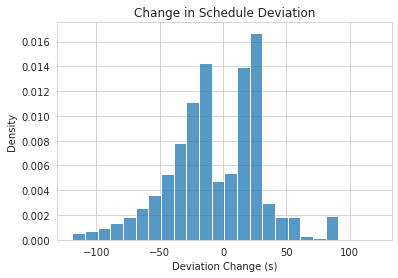

In [7]:
sns.histplot(data=all_data[(all_data['deviation_change_s']<120) & (all_data['deviation_change_s']>-120)], x='deviation_change_s', stat='density', binwidth=10)
plt.title('Change in Schedule Deviation')
plt.ylabel('Density')
plt.xlabel('Deviation Change (s)')

Text(0.5, 0, 'Speed (mph)')

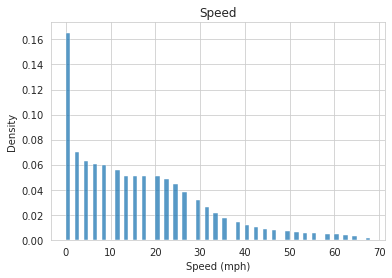

In [8]:
sns.histplot(data=all_data, x='speed_mph', stat='density', binwidth=1)
plt.title('Speed')
plt.ylabel('Density')
plt.xlabel('Speed (mph)')

Text(0.5, 0, 'Pace (s/mi)')

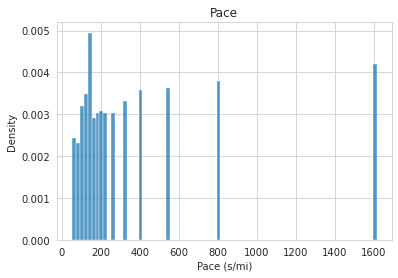

In [9]:
sns.histplot(data=all_data[all_data['pace_s_mi']<9999999], x='pace_s_mi', stat='density', binwidth=20)
plt.title('Pace')
plt.ylabel('Density')
plt.xlabel('Pace (s/mi)')

### Spatial Heatmaps

In [10]:
# Need to sample to run on normal computer
sampled = all_data.sample(1000000)
# del all_data

In [11]:
# Get daily metric for deviation change
dates = []
times = sampled.locationtime.values
TZ = pytz.timezone('America/Los_Angeles')
for time in times:
    dates.append(datetime.utcfromtimestamp(time).replace(tzinfo=pytz.utc).astimezone(TZ).strftime('%m_%d_%Y'))
sampled['day'] = dates
to_plot_med = sampled.groupby(['day', 'seg_compkey']).sum()[['deviation_change_s']].reset_index()
to_plot_med = sampled.groupby(['seg_compkey']).median()[['deviation_change_s']].reset_index()

# Get overall performance metric for speed
to_plot_spd = sampled.groupby(['seg_compkey']).median()[['speed_mph', 'deviation_change_s', 'pace_s_mi']]
to_plot_95 = sampled.groupby(['seg_compkey']).quantile(.95)[['speed_mph']]
to_plot = pd.merge(to_plot_95, to_plot_spd, on='seg_compkey')
#to_plot = pd.merge(to_plot, to_plot_med, on='seg_compkey')
to_plot['performance'] = to_plot['speed_mph_y'] / to_plot['speed_mph_x']
to_plot['performance'] = np.nan_to_num(to_plot['performance'])
metric_lookup = to_plot.to_dict(orient='index')

# Keep track of all values for the linear colormapping
speeds = np.array(to_plot['speed_mph_y'])
deviations = np.array(to_plot['deviation_change_s'])
performances = np.array(to_plot['performance'])
paces = np.nan_to_num(np.array(to_plot['pace_s_mi']))

# Write speeds from dict to temp geojson file
with open(f"{path}/../streets_0001buffer.geojson", 'r') as shapefile:
    streets = json.load(shapefile)
for feature in streets['features']:
    compkey = feature['properties']['COMPKEY']
    if compkey in metric_lookup.keys():
        speed = metric_lookup[compkey]['speed_mph_y']
        dev_change = metric_lookup[compkey]['deviation_change_s']
        performance = metric_lookup[compkey]['performance']
        pace = metric_lookup[compkey]['pace_s_mi']
        feature['properties']['MED_SPEED_M_S'] = speed
        feature['properties']['DEVIATION_CHG_S'] = dev_change
        feature['properties']['PERFORMANCE'] = performance
        feature['properties']['PACE'] = pace
    else:
        feature['properties']['MED_SPEED_M_S'] = 0
        feature['properties']['DEVIATION_CHG_S'] = 0
        feature['properties']['PERFORMANCE'] = 0
        feature['properties']['PACE'] = 0
with open(f"{path}/../streets_0001buffer_tmp.geojson", 'w+') as new_shapefile:
    json.dump(streets, new_shapefile)

In [12]:
# Initialize the map
f_map = folium.Map(
    location=[47.606209, -122.332069],
    zoom_start=11,
    prefer_canvas=True)

# Add street segments

# linear_cm_spd = cm.LinearColormap(
#     ['red', 'white', 'blue'],
#     vmin=np.min(speeds),
#     vmax=np.percentile(speeds, 95))
# folium.GeoJson(
#     name='Seattle Streets Median Speed',
#     data=f"{path}/../streets_0001buffer_tmp.geojson",
#     style_function=lambda feature: {
#         'color': 'gray' if feature['properties']['MED_SPEED_M_S'] == 0 \
#             else linear_cm_spd(feature['properties']['MED_SPEED_M_S']),
#         'weight': 2 if feature['properties']['MED_SPEED_M_S'] == 0 \
#             else 3},
#     highlight_function=lambda feature: {
#         'fillColor': '#ffaf00', 'color': 'blue', 'weight': 6},
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['MED_SPEED_M_S'],
#         aliases=['Speed (m/s)'])
# ).add_to(f_map)
# linear_cm_spd.add_to(f_map)

linear_cm_dev = cm.LinearColormap(
    ['blue', 'white', 'red'],
    vmin=np.percentile(deviations, 1),
    vmax=np.percentile(deviations, 99))
folium.GeoJson(
    name='Seattle Streets Median Deviation Change',
    data=f"{path}/../streets_0001buffer_tmp.geojson",
    style_function=lambda feature: {
        'color': 'gray' if feature['properties']['DEVIATION_CHG_S'] == 0 \
            else linear_cm_dev(feature['properties']['DEVIATION_CHG_S']),
        'weight': 2 if feature['properties']['DEVIATION_CHG_S'] == 0 \
            else 3},
    highlight_function=lambda feature: {
        'fillColor': '#ffaf00', 'color': 'blue', 'weight': 3},
    tooltip=folium.features.GeoJsonTooltip(
        fields=['DEVIATION_CHG_S'],
        aliases=['Deviation Change (s)'])
).add_to(f_map)
linear_cm_dev.add_to(f_map)

# linear_cm_per = cm.LinearColormap(
#     ['red', 'white', 'blue'],
#     #vmin=np.min(performances),
#     vmin=np.percentile(performances, 0),
#     vmax=np.percentile(performances, 100))
# folium.GeoJson(
#     name='Seattle Streets Performance',
#     data=f"{path}/../streets_0001buffer_tmp.geojson",
#     style_function=lambda feature: {
#         'color': 'gray' if feature['properties']['PERFORMANCE'] == 0 \
#             else linear_cm_per(feature['properties']['PERFORMANCE']),
#         'weight': 2 if feature['properties']['PERFORMANCE'] == 0 \
#             else 3},
#     highlight_function=lambda feature: {
#         'fillColor': '#ffaf00', 'color': 'blue', 'weight': 6},
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['PERFORMANCE'],
#         aliases=['Median Speed / 95th Percentile'])
# ).add_to(f_map)
# linear_cm_per.add_to(f_map)

# linear_cm_per = cm.LinearColormap(
#     ['blue', 'white', 'red'],
#     vmin=np.percentile(paces, 0),
#     vmax=np.percentile(paces, 90))
# folium.GeoJson(
#     name='Seattle Streets Pace',
#     data=f"{path}/../streets_0001buffer_tmp.geojson",
#     style_function=lambda feature: {
#         'color': 'gray' if feature['properties']['PACE'] == 0 \
#             else linear_cm_per(feature['properties']['PACE']),
#         'weight': 2 if feature['properties']['PACE'] == 0 \
#             else 3},
#     highlight_function=lambda feature: {
#         'fillColor': '#ffaf00', 'color': 'blue', 'weight': 6},
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['PACE'],
#         aliases=['1 / Median Speed'])
# ).add_to(f_map)
# linear_cm_per.add_to(f_map)

# Create and add layer for all the sampled coordinate data
# lats = sampled['lat'].tolist()
# lons = sampled['lon'].tolist()
# points = zip(lats, lons)
# points = list(points)
# HeatMap(
#     data=points,
#     name='Points',
#     radius=8,
#     min_opacity=0.2
# ).add_to(f_map)


folium.GeoJson(
    name='Study Corridors',
    data=f"{path}/../study_corridors.geojson",
    style_function=lambda feature: {
        'color': 'purple',
        'weight': 4
    }
).add_to(f_map)
folium.LayerControl().add_to(f_map)

# Save map and plot in notebook
f_map.save(f"./local_sampled_map.html")
f_map

### Create Distributions of Metrics for Buses with/without Interference

In [16]:
interference_data = pd.read_csv(f"{path}/../interference_instances_new.csv")
interference_data['start_time'] = pd.to_datetime(interference_data['int_start_time']).dt.tz_localize(tz.tzlocal()).astype(int).astype(str).str.slice(0,10).astype(int)
interference_data['stop_time'] = pd.to_datetime(interference_data['int_stop_time']).dt.tz_localize(tz.tzlocal()).astype(int).astype(str).str.slice(0,10).astype(int)
interference_data['corridor_id'] = interference_data['corridor_id'] - 1
interference_data.head()

Unnamed: 0  corridor_id                      corridor_name  vehicle_id  \
0           1            1                Pike;\r\n3rd to 9th        7151   
1           2            1                Pike;\r\n3rd to 9th        9647   
2           3            1                Pike;\r\n3rd to 9th        4508   
3           4            5  University Way;\r\nCampus to 45th        6895   
4           5            5  University Way;\r\nCampus to 45th        8048   

   int_location_tyoe        lat         lon             mode  \
0  In a driving lane  47.610556 -122.335928     Construction   
1  In a driving lane  47.610657 -122.335785     Construction   
2  In a driving lane  47.610609 -122.336568     Construction   
3  In a driving lane  47.658530 -122.313270  Service Vehicle   
4  In a driving lane  47.658636 -122.313270       Pedestrian   

        int_start_time        int_stop_time first_name  difference  \
0  2021-03-05 07:19:24  2021-03-05 07:19:26     Travis           2   
1  2021-03-05 07:36:34  2021-03-05 07:36:36     Travis           2   
2  2021-03-05 07:38:58  2021-03-05 07:39:00     Travis           2   
3  2021-03-08 07:48:09  2021-03-08 07:48:11     Andrew           2   
4  2021-03-08 08:04:34  2021-03-08 08:04:38     Andrew           4   

  report_date  start_time   stop_time  
0  2021-03-05  1614957564  1614957566  
1  2021-03-05  1614958594  1614958596  
2  2021-03-05  1614958738  1614958740  
3  2021-03-08  1615218489  1615218491  
4  2021-03-08  1615219474  1615219478

In [58]:
# Track down the datapoints in GTFS-RT that correspond to each interference instance
idx_interference = []  # The index of the interference in the interference data
data_interference = []  # Data for +/- xmins from the interference in GTFS-RT
datarow_interference = []  # What row of the +/- xmins GTFS-RT data the interference corresponds to

for idx, row in interference_data.iterrows():

    # Get the tracked datapoints corresponding to +/- xmins of the data; FROM THE START of the interference
    found = False
    margin_mins = 2
    margin = margin_mins*60  # xmins in seconds
    data = bus_interference_data[bus_interference_data['vehicleid'] == row.vehicle_id]
    data = data[(data['locationtime']>=(row.start_time - margin)) & (data['locationtime']<=(row.start_time + margin))]
    
    # Get the metric across the time period where the interference occurred
    if len(data) > 0:
        data = data.sort_values(by='locationtime', ascending=True)
        for j, time in enumerate(data['locationtime']):
            if row.start_time <= time:
                idx_interference.append(idx)
                datarow_interference.append(j-1)
                # Get time variable for each interference that is +/- seconds from 0; where 0 is the time of the interference
                data['time_from_interference'] = data['locationtime'] - data['locationtime'].iloc[j-1]
                # Get schedule deviation variable for each location with interference at 0
                data['deviation_from_interference'] = data['scheduledeviation'] - data['scheduledeviation'].iloc[j-1]
                data['interference_id'] = str(idx)
                data_interference.append(data)
                found = True
                break
        if not found:
            print(f"Interference {idx} vehicle id {row.vehicle_id} Fell outside data")
    else:
        print(f"Interference {idx} vehicle id {row.vehicle_id} No data found")
        continue

Interference 1 vehicle id 9647 No data found
Interference 14 vehicle id 4370 No data found
Interference 19 vehicle id 8142 No data found
Interference 21 vehicle id 7196 No data found
Interference 22 vehicle id 9641 No data found
Interference 23 vehicle id 303 No data found
Interference 24 vehicle id 7425 No data found
Interference 25 vehicle id 41514 No data found
Interference 26 vehicle id 9672 No data found


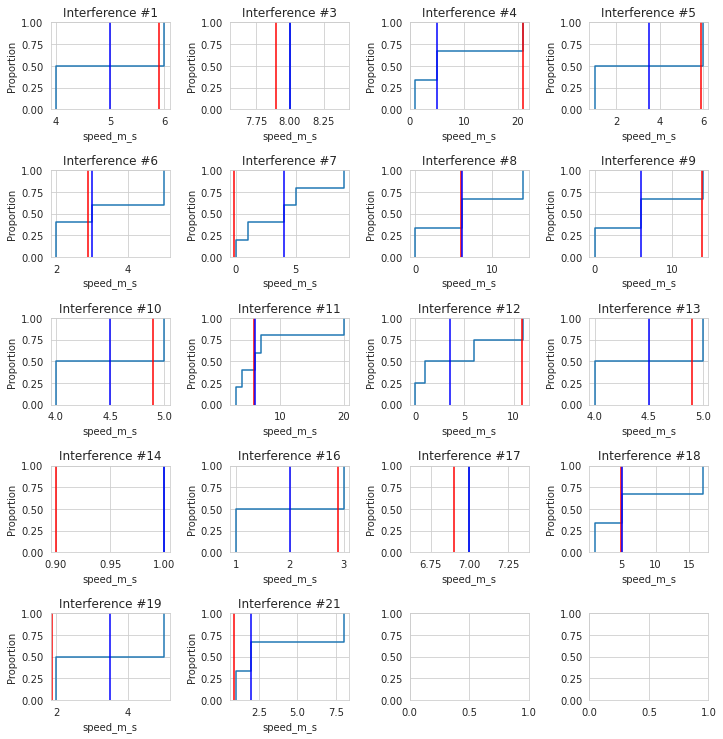

In [38]:
fig, axes = plt.subplots(5,4,figsize=(10,10))
fig.tight_layout(h_pad=4, w_pad=2)

for i, idx in enumerate(idx_interference):
    sns.ecdfplot(data=data_interference[i], x='speed_m_s', ax=axes.flat[i]).set(title=f"Interference #{idx+1}")
    axes.flat[i].axvline(data_interference[i]['speed_m_s'].iloc[datarow_interference[i]]-.1, color='red')
    axes.flat[i].axvline(np.median(data_interference[i]['speed_m_s']), color='blue')

fig.savefig(fname="interference_speeds")

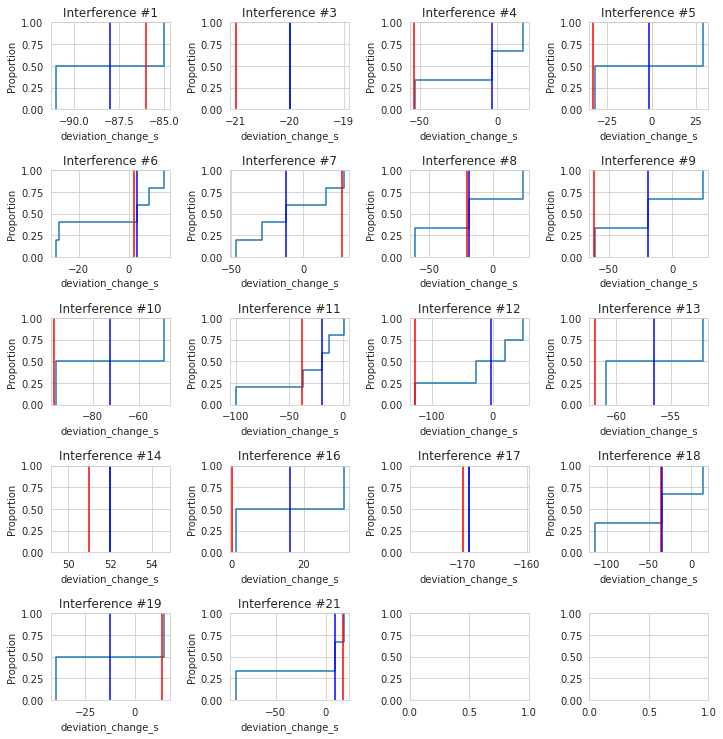

In [44]:
fig, axes = plt.subplots(5,4,figsize=(10,10))
fig.tight_layout(h_pad=4, w_pad=2)

for i, idx in enumerate(idx_interference):
    sns.ecdfplot(data=data_interference[i], x='deviation_change_s', ax=axes.flat[i]).set(title=f"Interference #{idx+1}")
    axes.flat[i].axvline(data_interference[i]['deviation_change_s'].iloc[datarow_interference[i]]-1, color='red')
    axes.flat[i].axvline(np.median(data_interference[i]['deviation_change_s']), color='blue')

fig.savefig(fname="interference_deviation_changes")

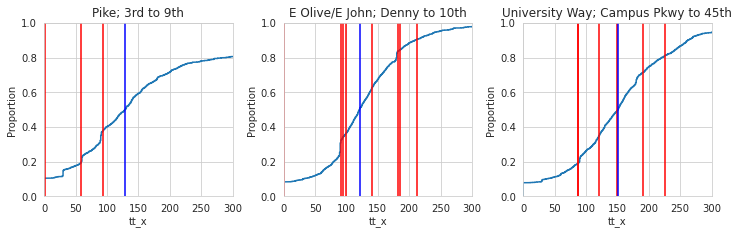

In [74]:
fig, axes = plt.subplots(1,3,figsize=(10,3))
fig.tight_layout(h_pad=4, w_pad=2)

last_ax_used = -1
for i in range(9):  # No Bellevue corridor because using the Seattle Streets dataset to map match coords
    if i in [0,2,4,6,7,8]:
        continue
    else:
        last_ax_used += 1
    full_data = bus_interference_data[bus_interference_data['corridor_id']==i]
    sns.ecdfplot(data=full_data, x='tt_x', ax=axes.flat[last_ax_used]).set(xlim=(0,60*5), title=f"{corridor_names[i]}")
    for j in range(len(idx_interference)):
        if data_interference[j]['corridor_id'].iloc[datarow_interference[j]]==i:
            axes.flat[last_ax_used].axvline(data_interference[j]['tt_x'].iloc[datarow_interference[j]]+1, color='red')
    axes.flat[last_ax_used].axvline(np.median(full_data['tt_x']), color='blue')
    
fig.savefig(fname="corridor_traversal_times")

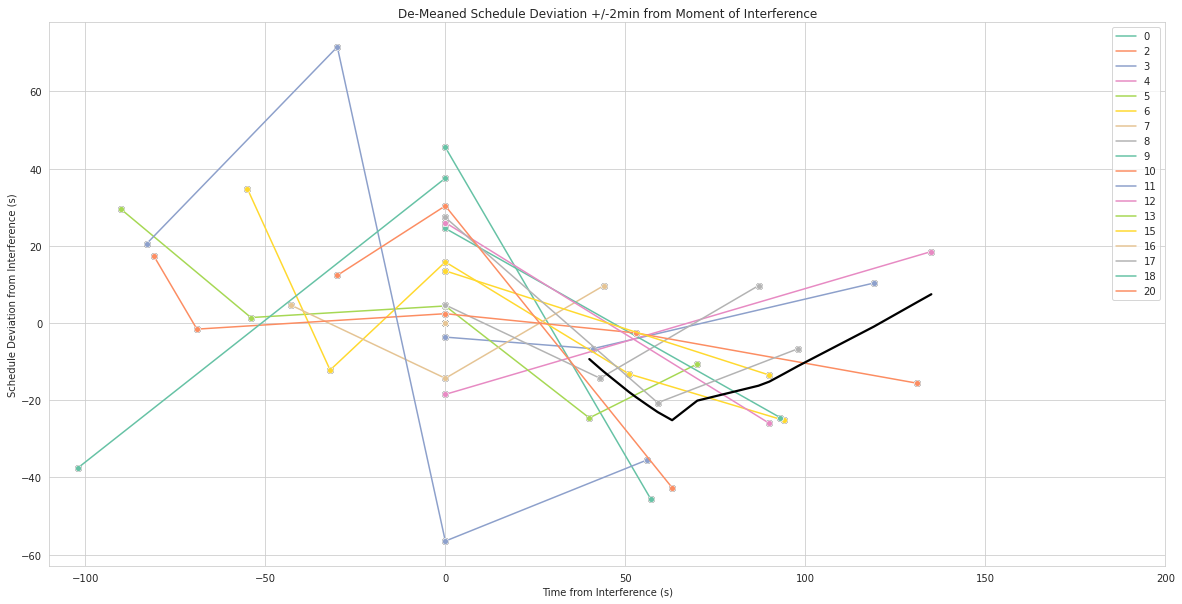

In [75]:
# Create column for de-meaned values in the timeseries data
for i in range(len(data_interference)):
    norm = np.mean(data_interference[i]['scheduledeviation'])
    data_interference[i]['scheduledeviation_norm'] = data_interference[i]['scheduledeviation'] - norm

fig, axes = plt.subplots(1,1,figsize=(20,10))

# Event study timeseries plot per interference
sns.lineplot(data=pd.concat(data_interference),
             x="time_from_interference",
             y="scheduledeviation_norm",
             hue="interference_id",
             palette='Set2',
             marker='o',
             ax=axes).set(xlim=(-120,120), xlabel='Time from Interference (s)', ylabel='Schedule Deviation (s)', title=f"De-Meaned Schedule Deviation +/-{margin_mins}min from Moment of Interference")

# LOWESS regression for data before interference
sns.regplot(data=pd.concat(data_interference)[pd.concat(data_interference)['time_from_interference']<=0],
             x="time_from_interference",
             y="scheduledeviation_norm",
             lowess=True,
             color='black').set(xlim=(-110,200), xlabel='Time from Interference (s)', ylabel='Schedule Deviation from Interference (s)')

# LOWESS regression for data after interference
sns.regplot(data=pd.concat(data_interference)[pd.concat(data_interference)['time_from_interference']>0],
             x="time_from_interference",
             y="scheduledeviation_norm",
             lowess=True,
             color='black').set(xlim=(-110,200), xlabel='Time from Interference (s)', ylabel='Schedule Deviation from Interference (s)')
plt.legend(loc='upper right')

fig.savefig(fname="event_study_plot")